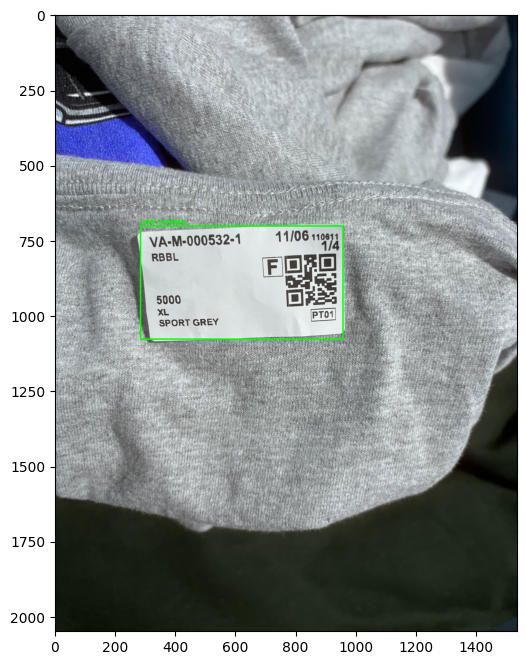

In [5]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def find_label_on_tshirt(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return

    h, w = img.shape[:2]
    # Dictionary to store detected rectangles: {(x, y, w, h): count}
    detected_candidates = []

    # 1. Iterate through color channels (B, G, R)
    channels = cv2.split(img)

    # 2. Try various threshold values (e.g., from 150 to 230)
    # White labels are usually very bright (> 200)
    for channel in channels:
        for thresh_val in range(180, 241, 20):
            _, binary = cv2.threshold(channel, thresh_val, 255, cv2.THRESH_BINARY)

            # Find contours in the binary image
            contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            for cnt in contours:
                # Filter by area (too small is noise, too big is the shirt)
                area = cv2.contourArea(cnt)
                if area < (h * w * 0.005) or area > (h * w * 0.2):
                    continue

                # Check for "rectangle-like" shape
                peri = cv2.arcLength(cnt, True)
                approx = cv2.approxPolyDP(cnt, 0.04 * peri, True)

                # If it has 4 corners, it's a rectangle candidate
                if len(approx) == 4:
                    x, y, w_box, h_box = cv2.boundingRect(approx)
                    # Check aspect ratio (labels are usually not extremely thin)
                    aspect_ratio = float(w_box) / h_box
                    if 0.2 < aspect_ratio < 5.0:
                        detected_candidates.append((x, y, w_box, h_box))

    # 3. Filter for persistence: Group rectangles that are nearly identical
    # If a rectangle appears in multiple thresholds/channels, it's likely the label
    output_img = img.copy()
    if detected_candidates:
        # cv2.groupRectangles merges overlapping boxes
        # groupThreshold=3 means it must appear at least 3 times to be kept
        final_boxes, weights = cv2.groupRectangles(detected_candidates, groupThreshold=3, eps=0.1)

        for (x, y, wb, hb) in final_boxes:
            cv2.rectangle(output_img, (x, y), (x + wb, y + hb), (0, 255, 0), 3)
            cv2.putText(output_img, "Label Candidate", (x, y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    plt.figure(figsize=(10, 8))
    plt.imshow(output_img)
    #plt.title(f"All Detected and Aligned Labels (Total: {len(final_aligned_labels)})")
    plt.show()

    #cv2.imshow("Detected Label", output_img)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()

# Usage
find_label_on_tshirt('signal-2025-12-26-164746.jpeg')